In [ ]:
#grad min is 0


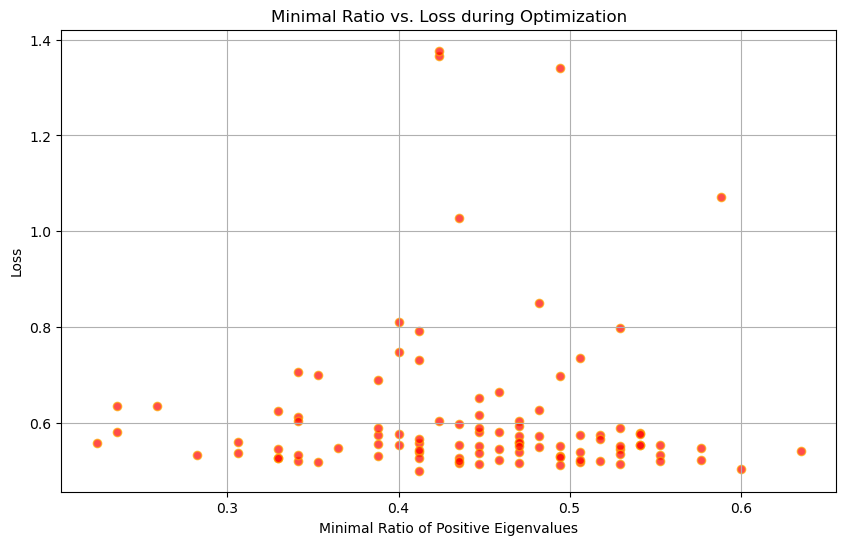

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Create random data between (-10, 10) and determine groundtruth
sim_in = 20 * torch.rand((1000, 1)) - 10
groundTruth = torch.cos(sim_in)

# Calculate the number of parameters in a neural network
def calcParams(inputModel):
    return sum(p.numel() for p in inputModel.parameters() if p.requires_grad)

# Set up NN for cos(x) training - Shallow Network with 2 Hidden Layers
class OptimizeNN(nn.Module):
    def __init__(self):
        super(OptimizeNN, self).__init__()
        self.fc1 = nn.Linear(1, 9)
        self.fc2 = nn.Linear(9, 6)
        self.fc3 = nn.Linear(6, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Auxiliary function to calculate minimal eigenvalue ratio
def min_ratio(w):
    count = (w > 0).sum()  # count positive eigenvalues
    total = len(w)
    return count / total if total > 0 else 0

# Function to calculate the gradient norm
def calculate_grad_norm(model):
    grads = [p.grad.norm(2).item() for p in model.parameters() if p.grad is not None]
    return np.mean(grads) if grads else 0

# Initialize lists to store loss and minRatio values
minRatio = []
Loss = []

# Set number of training iterations
train_count = 100
EPOCHS = 100

for i in range(train_count):
    lss = 0

    # Initialize model, loss function, and optimizer
    optimNet = OptimizeNN()
    costFunc = nn.MSELoss()
    opt = torch.optim.Adam(optimNet.parameters(), lr=0.001)

    # Training loop
    for epochIndex in range(EPOCHS):
        optimNet.zero_grad()
        output = optimNet(sim_in)
        cost = costFunc(output, groundTruth)
        cost.backward()
        opt.step()

        lss += cost.item()

    # Append the average loss for this iteration
    Loss.append(lss / EPOCHS)

    # Calculate Hessian
    num_param = calcParams(optimNet)
    H = torch.zeros((num_param, num_param))

    y_hat = optimNet(sim_in)
    loss = costFunc(y_hat, groundTruth)

    # Calculate the Jacobian w.r.t. model parameters
    J = torch.autograd.grad(loss, optimNet.parameters(), create_graph=True)
    J = torch.cat([j.view(-1) for j in J])  # flatten

    # Fill the Hessian matrix
    for i in range(num_param):
        result = torch.autograd.grad(J[i], optimNet.parameters(), retain_graph=True)
        H[i] = torch.cat([r.view(-1) for r in result])  # flatten

    # Eigen decomposition of the Hessian matrix
    eigenvalues, _ = np.linalg.eig(H.detach().numpy())
    minRatio.append(min_ratio(eigenvalues))

# Plot Minimal Ratio vs. Loss
plt.figure(figsize=(10, 6))
plt.scatter(minRatio, Loss, color="red", edgecolor="orange", alpha=0.7)
plt.xlabel('Minimal Ratio of Positive Eigenvalues')
plt.ylabel('Loss')
plt.title('Minimal Ratio vs. Loss during Optimization')
plt.grid(True)
plt.show()
